In [55]:
import pandas as pd
import numpy as np
import math

In [56]:
df_migrations = pd.read_csv('origin_x_destination_migrations.csv')
df_migrations.sample(n=5)

Region, development group, country or area of destination  \
11164                                          Greenland          
10964                                             Canada          
1965                                         Philippines          
714                                       Western Sahara          
3234                                             Czechia          

       Notes of destination  Location code of destination  \
11164                  31.0                           304   
10964                   NaN                           124   
1965                    NaN                           608   
714                     NaN                           732   
3234                    NaN                           203   

      Type of data of destination  \
11164                           B   
10964                           B   
1965                          C R   
714                             I   
3234                            C   

      Region, development group, country or area of origin  \
11164                                            Iceland     
10964                                            Austria     
1965                                               Spain     
714                                           Mauritania     
3234                    Bolivia (Plurinational State of)     

       Location code of origin   1990   1995   2000   2005   2010   2015  \
11164                      352     21     25    123    104     95    163   
10964                       40  25600  23600  22161  19097  17095  15747   
1965                       724    257    345     83     67   1284   1305   
714                        478    282    313    345    408    471    542   
3234                        68     12     18     24     49     69     78   

        2020  
11164    159  
10964  17061  
1965    1388  
714      566  
3234      99

In [57]:
df_countries = pd.read_csv('countries_list.csv')
df_countries.sample(n=5)

country
117   Slovakia
172    Jamaica
124    Iceland
136  Gibraltar
50        Mali

In [58]:
destination_label = 'Region, development group, country or area of destination'
origin_label = 'Region, development group, country or area of origin'

In [59]:
year = '2010'
years_after_year_to_rank = 10
enable_current_migrants_relevance = True

In [60]:
df_migrations['flow'] = df_migrations[year] - df_migrations[str(int(year) - 5)]
df_migrations[[destination_label, origin_label, 'flow']].sample(5)

Region, development group, country or area of destination  \
2309                                            Bahrain          
1170                                             Guinea          
832                                             Namibia          
9847                                             Mexico          
8315                                         Luxembourg          

     Region, development group, country or area of origin  flow  
2309                           United States of America     398  
1170                                              Congo       0  
832                                          Mozambique      -6  
9847                                             Canada    1960  
8315                                              Japan     -30

In [61]:
df_migrations.loc[df_migrations[origin_label] == 'Brazil'][[destination_label, origin_label, '2000', '2005', 'flow']].sort_values(by=['flow'], ascending=False).head(10)

Region, development group, country or area of destination  \
11195                           United States of America          
7201                                               Spain          
6494                                               Italy          
6810                                            Portugal          
1698                                               Japan          
7977                                             Germany          
7785                                              France          
11345                                          Australia          
1621                                               China          
10074                                          Argentina          

      Region, development group, country or area of origin    2000    2005  \
11195                                             Brazil    217822  280274   
7201                                              Brazil     28179   68502   
6494                                              Brazil     28883   66536   
6810                                              Brazil     49599   91614   
1698                                              Brazil    254413  217455   
7977                                              Brazil     23338   38846   
7785                                              Brazil     21756   42128   
11345                                             Brazil      4750    7529   
1621                                              Brazil     23509   33986   
10074                                             Brazil     32925   37609   

        flow  
11195  72683  
7201   64147  
6494   44000  
6810   26801  
1698   13097  
7977   12614  
7785   11778  
11345   9021  
1621    8945  
10074   4674

In [62]:
group_by_origin = df_migrations.groupby([origin_label])

In [63]:
df_migrations_weight = pd.DataFrame(data={'origin': [], 'destination': [], 'weight': []})

for name, group in group_by_origin:
    migrants_positive_flow_sum = group.loc[group['flow'] > 0]['flow'].sum()
#     migrants_negative_flow_sum = group.loc[group['flow'] < 0]['flow'].sum() * (-1)
    if(enable_current_migrants_relevance):
        net_migrations = df_migrations.loc[df_migrations[destination_label] == name].loc[df_migrations['flow'] > 0, 'flow'].sum() + df_migrations.loc[df_migrations[destination_label] == name].loc[df_migrations['flow'] < 0, 'flow'].sum()
#         print(name, ':', 
#                   df_migrations.loc[df_migrations[destination_label] == name, year].sum(), 
#                   '/', df_migrations.loc[:, year].sum(), '=', 
#                   df_migrations.loc[df_migrations[destination_label] == name, year].sum()/df_migrations.loc[:, year].sum())
        if(net_migrations > 0):
#             print(name, ':', net_migrations, '/', df_migrations.loc[df_migrations['flow'] > 0, 'flow'].sum(), '=', net_migrations/df_migrations.loc[df_migrations['flow'] > 0, 'flow'].sum())
            new_row = pd.DataFrame({
                'origin': name, 
                'destination': name, 
                'weight': net_migrations/df_migrations.loc[df_migrations['flow'] > 0, 'flow'].sum()
            }, index=[0])
            df_migrations_weight = pd.concat([new_row, df_migrations_weight.loc[:]]).reset_index(drop=True)

    for index, row in group.iterrows():
#         if (row['flow'] > 0):
#             weight = row['flow']/migrants_positive_flow_sum
#         else:
#             if (migrants_negative_flow_sum):
#                 weight = row['flow']/migrants_negative_flow_sum
#             else:
#                 weight = 0
        if (row['flow'] > 0):
            weight = row['flow']/migrants_positive_flow_sum
            new_row = pd.DataFrame({
                'origin': name, 
                'destination': row[destination_label], 
                'weight': weight
            }, index=[0])
            df_migrations_weight = pd.concat([new_row, df_migrations_weight.loc[:]]).reset_index(drop=True)

df_migrations_weight.sort_values(by=['weight'], ascending=False).head(5)

origin   destination    weight
933          Tokelau     Australia  1.000000
6570    Cook Islands     Australia  0.998294
8136  American Samoa          Mali  0.993827
3978         Lesotho  South Africa  0.988083
3323      Mozambique  South Africa  0.986757

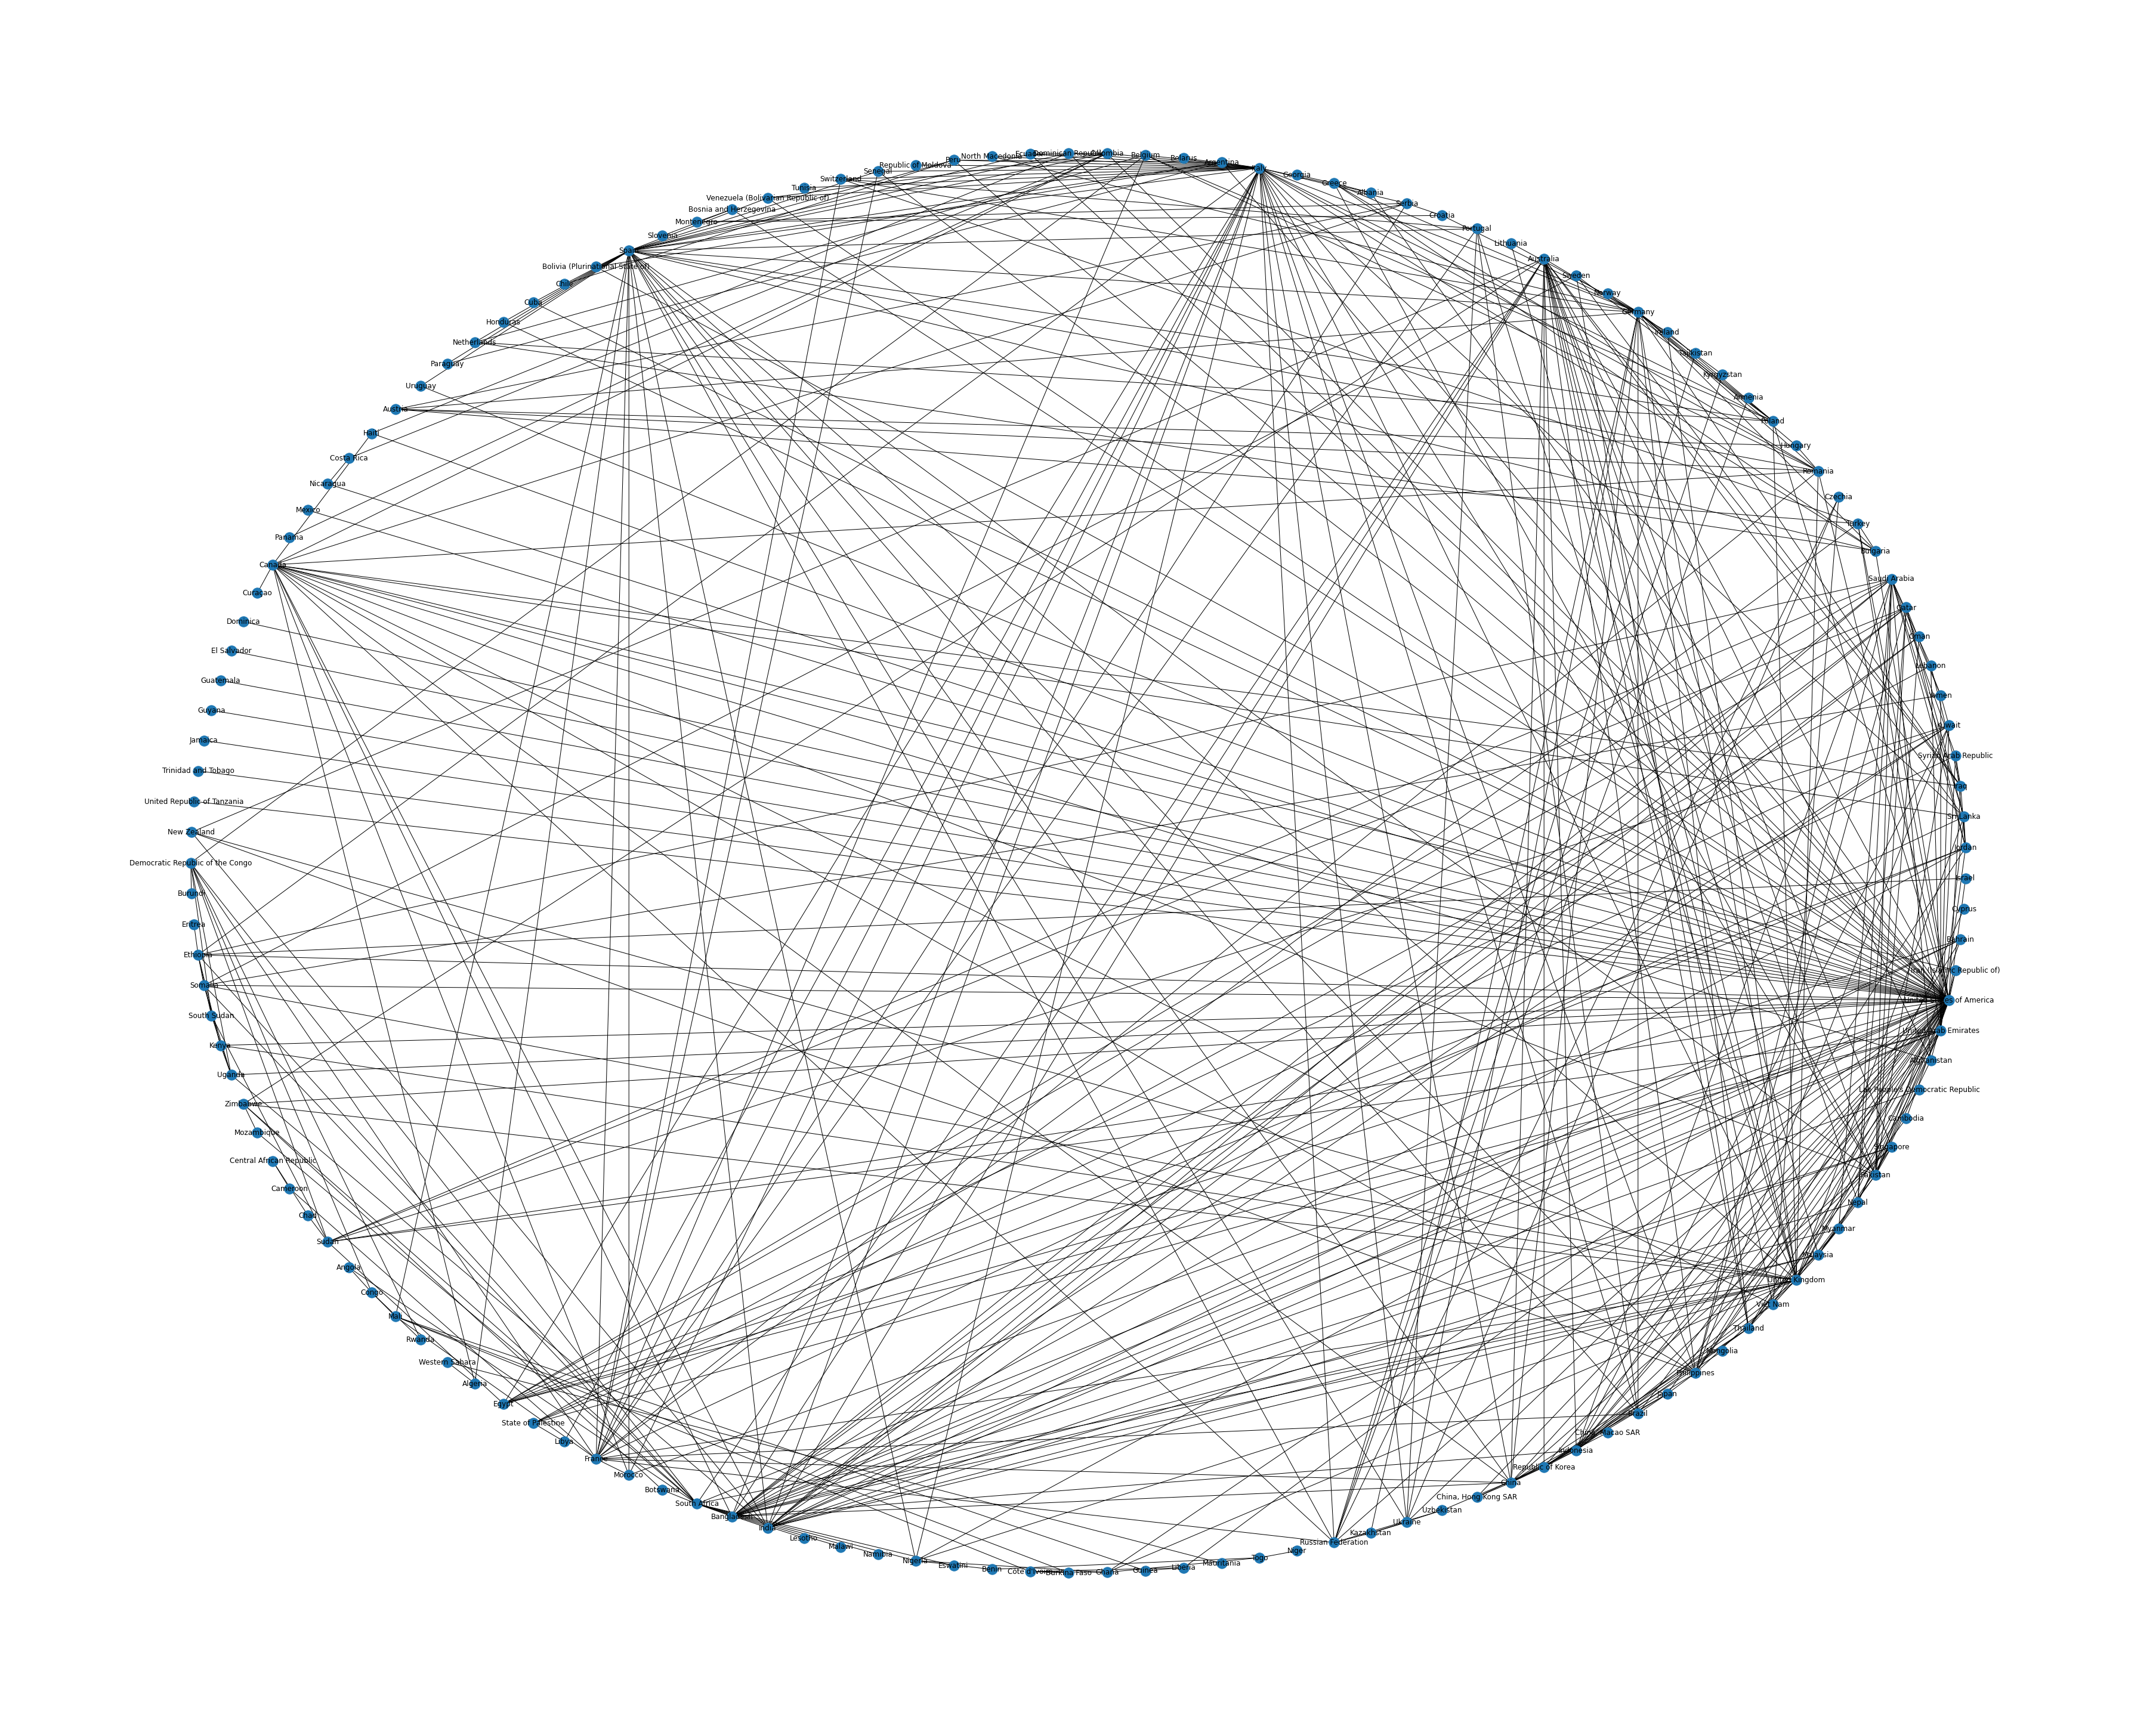

In [64]:
min_people_flow = 10000
df_to_newtork = df_migrations[df_migrations['flow'] > min_people_flow]
# df_to_newtork = df_to_newtork[df_to_newtork['origin'] == 'Brazil']
df1 = df_to_newtork[[origin_label, destination_label]]
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(df1, origin_label, destination_label)
from matplotlib.pyplot import figure
figure(figsize=(50, 40))
nx.draw_shell(G, with_labels=True)

In [65]:
# Normalize weight
for country in df_migrations_weight['origin'].unique():
    df_migrations_weight.loc[df_migrations_weight['origin'] == country, 'weight'] = df_migrations_weight.loc[df_migrations_weight['origin'] == country, 'weight'] + abs(df_migrations_weight.loc[df_migrations_weight['origin'] == country, 'weight'].min())
    df_migrations_weight.loc[df_migrations_weight['origin'] == country, 'weight'] = df_migrations_weight.loc[df_migrations_weight['origin'] == country, 'weight'] / df_migrations_weight.loc[df_migrations_weight['origin'] == country, 'weight'].sum()

In [66]:
flow_matrix = []

for idx_origin, country_origin in df_countries.iterrows():
    flow_matrix.append([])
    for idx_destination, country_destination in df_countries.iterrows():
        flow_matrix[idx_origin].append(0.0)
        countries_migration = df_migrations_weight.loc[df_migrations_weight['origin'] == country_origin['country']].loc[df_migrations_weight['destination'] == country_destination['country']]
        if(len(countries_migration) == 0):
            continue
        flow_matrix[idx_origin][idx_destination] = countries_migration['weight'].values[0]
        
flow_matrix = np.array(flow_matrix)
flow_matrix

array([[1.59237396e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.50984528e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.79275742e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [67]:
migrants_count_list = [] 
migrants_total = df_migrations.loc[df_migrations['flow'] > 0]['flow'].sum()

for idx, country in df_countries.iterrows(): 
    migrants_in_country = df_migrations.loc[df_migrations[origin_label] == country['country']].loc[df_migrations['flow'] > 0]['flow'].sum()
    migrants_count_list.append([migrants_in_country/migrants_total])
    
migrants_count_list

[[0.0005486775882659049],
 [0.00037483199762500534],
 [5.240487410948888e-05],
 [0.0024092094218015766],
 [0.005540797656465579],
 [0.0024591600731566268],
 [0.00036114609661789913],
 [0.00112100233460105],
 [0.0005542789907878006],
 [2.0211246213026015e-07],
 [0.005350494336765502],
 [7.507034307695377e-06],
 [0.0018713592868640787],
 [7.57633000899718e-05],
 [0.01553182299695073],
 [0.006829755447096875],
 [0.0058672670292237005],
 [0.0009177349441157599],
 [0.0003723489016616907],
 [0.007375776700146211],
 [0.001268659924791643],
 [0.0016984087656983277],
 [0.003453899865344016],
 [0.00046046993515048415],
 [0.0006898675796683294],
 [0.009103722758524432],
 [0.00038505311356702135],
 [0.0001113928398426491],
 [7.709146769825637e-05],
 [0.0017344714035841412],
 [0.02330212322317521],
 [0.0008928462380648621],
 [0.011444589294917106],
 [0.0073320915351171995],
 [0.0012534148705052462],
 [0.0011256220480211703],
 [0.0003341207731101958],
 [0.0006987316547931851],
 [0.002473798790056632

In [68]:
migrants_per_year = migrants_count_list
for i in range(0, math.ceil(years_after_year_to_rank/5)):
    migrants_per_year = np.matmul(flow_matrix.transpose(), migrants_per_year)

# Rank - Previsão de países com maior fluxo migratório no ano definido

In [69]:
rank = pd.DataFrame(data={
    'country': df_countries['country'].tolist(), 
    'rank': [item for sublist in migrants_per_year for item in sublist]
})
print("Previsão de países com maior fluxo migratório no ano de", int(year) + years_after_year_to_rank)
rank.sort_values(by=['rank'], ascending=False).head(10).reset_index()

Previsão de países com maior fluxo migratório no ano de 2020


index                   country      rank
0    211  United States of America  0.095528
1    190                    Mexico  0.068424
2    107      United Arab Emirates  0.067068
3    212                 Australia  0.059726
4    147                     Spain  0.055642
5    139                     Italy  0.055594
6     85                     India  0.048046
7    131            United Kingdom  0.047673
8    156               Switzerland  0.034657
9    103              Saudi Arabia  0.028241

<AxesSubplot: ylabel='rank'>

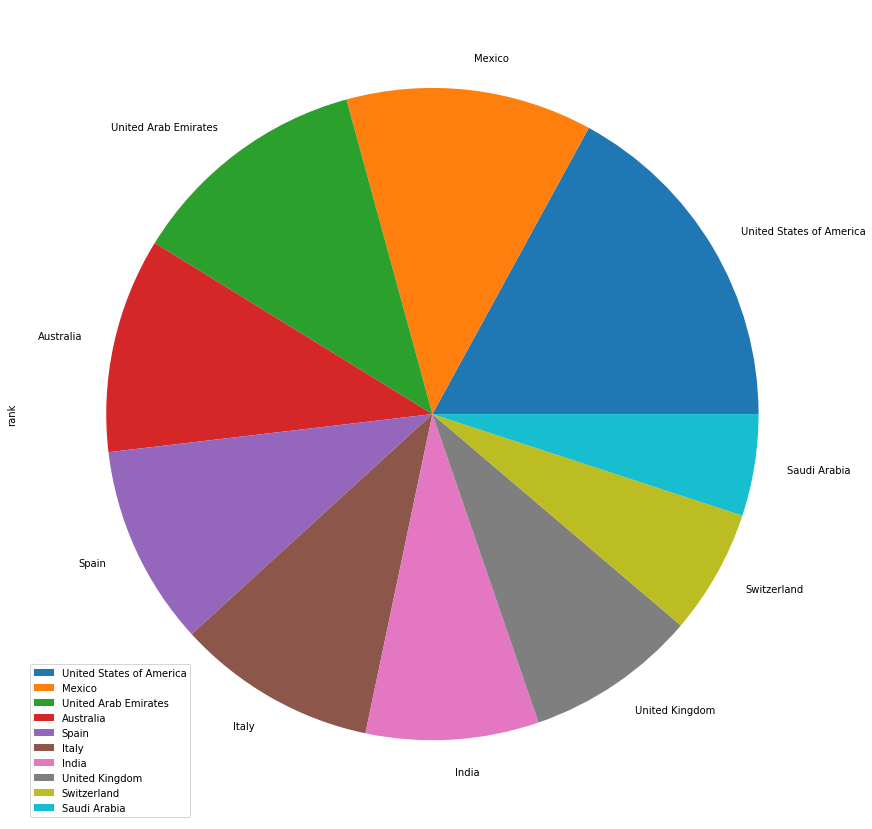

In [70]:
rank.sort_values(by=['rank'], ascending=False).head(10).set_index('country').plot(kind='pie', y='rank', figsize=(15, 15))

### Países com maior fluxo migratório real no ano previsto pelo PageRank

In [71]:
df_migrations['diff'] = df_migrations[str(int(year) + years_after_year_to_rank)] - df_migrations[year]
group_by_destination = df_migrations.groupby([destination_label])
group_by_destination['diff'].sum().sort_values(ascending=False).head(10)

Region, development group, country or area of destination
Germany                     5916923
Saudi Arabia                4854283
Turkey                      4651727
United States of America    4396190
United Kingdom              2242335
Colombia                    1772049
Australia                   1770274
Oman                        1493422
United Arab Emirates        1357056
Canada                      1293228
Name: diff, dtype: int64

In [72]:
group_by_destination['diff'].sum().sort_values(ascending=False).head(10).index.values

array(['Germany', 'Saudi Arabia', 'Turkey', 'United States of America',
       'United Kingdom', 'Colombia', 'Australia', 'Oman',
       'United Arab Emirates', 'Canada'], dtype=object)

### Intersecção de países do rank previsto pelo algoritmo e do rank real

In [73]:
inters = np.intersect1d(
    list(rank.sort_values(by=['rank'], ascending=False).head(10)['country']), 
    group_by_destination['diff'].sum().sort_values(ascending=False).head(10).index.values
)
print(*inters, sep='\n')

Australia
Saudi Arabia
United Arab Emirates
United Kingdom
United States of America


### Países que estão no rank real mas não foram previstos pelo algoritmo

In [74]:
diff = [item for item in group_by_destination['diff'].sum().sort_values(ascending=False).head(10).index.values if item not in list(rank.sort_values(by=['rank'], ascending=False).head(10)['country'])]
print(*diff, sep='\n')

Germany
Turkey
Colombia
Oman
Canada


In [75]:
# TODO: Code to generate Rank by time
# https://towardsdatascience.com/7-visualizations-with-python-to-express-changes-in-rank-over-time-71c1f11d7e4b

# ym = list(set(year_month))
# ym.sort()

# df_month['posi'] = [ym.index(i) for i in df_month['year_month']]
# df_month['CO_str'] = [str(round(i,2)) for i in df_month['CO']]
# df_month['CO_text'] = [str(round(i,2))+' ppm' for i in df_month['CO']]
# df_month.head()

# import plotly.express as px
# fig = px.scatter(df_month, x='posi', y='rank',
#                  size= 'CO',
#                  color='District', text='CO_text',
#                  color_discrete_map= dict_color,
#                  animation_frame='year_month',
#                  animation_group='District',
#                  range_x=[-2,len(ym)],
#                  range_y=[0.5,6.5]
#                 )
# fig.update_xaxes(title='', visible=False)
# fig.update_yaxes(autorange='reversed', title='Rank',
#                  visible=True, showticklabels=True)
# fig.update_layout(xaxis=dict(showgrid=False),
#                   yaxis=dict(showgrid=True))
# fig.update_traces(textposition='middle left')
# fig.show()